In [2]:
import os
import csv
import pandas as pd
import numpy as np
import math
from numpy.core.numeric import NaN
import scipy.stats as st
import itertools

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

import random







Part 1: Pre-Processing

In [3]:
#Loading data
vo9 = pd.read_csv(r'/content/vo.9.csv')

In [156]:
df_full_test.columns

Index(['vo.num', 'hh', 'clip', 'hand', 'coder', 'obsnum', 'cObj', 'cAct',
       'cFreq', 'event', 'loc', 'oAct', 'oObj', 'dur', 'timestamp', 'clip.S',
       'realtime', 'realtime.hrs', 'realtime.min', 'realtime.hr.half',
       'actobj.num', 'act', 'obj', 'obj.class', 'actobj', 'actobj.class', 'X',
       'htm', 'htm_cumul', 'htm/hr', 'record.cumulative', 'recorded_time',
       'recorded_seconds', 'recorded_minutes', 'recorded_hours'],
      dtype='object')

In [4]:
#Make a copy
df2 = vo9.copy()

#Focusing specifically on right hand because of cultural norms
dfact = df2[df2["hand"] == "R"]

#Exclusively want Hand to mouth exposures
#For our frequency column, 0 or 1 given exposure
dfact["htm"] = 0

indexer = (dfact['obj'] == 'ChildHand') & (dfact["act"]=='Touch')
dfact.loc[indexer, 'htm'] = 1
dfact.loc[~indexer, 'htm'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Algorithmic Processing

In [5]:
train, test = train_test_split(
    dfact, test_size=0.33, random_state=42)

In [6]:
#Build a Subset for each Round of video
def dict_subset_builder(percent_choice, df):
  round_1 = {}
  round_2 = {}
  round_3 = {}

  hh_list = df["hh"].unique()
  rounds = df["vo.num"].unique()

  count = 0

  df["htm_cumul"] = 0
  df["htm/hr"] = 0

  #go through all the children in hh_list
  for child in hh_list:


    #create sub dictionary
    vo_1 = {}
    vo_2 = {}
    vo_3 = {}


    count2 = 0

    for round in rounds:

      #specify the vo round and child
      df_vo = df[(df["vo.num"]== str(round)) & (df["hh"]== child)]

      #get the cumulative sum of recorded time
      df_vo["record.cumulative"] = df_vo["dur"].shift(1).cumsum().fillna(0)


      #creating hour running time variable
      df_vo["recorded_time"] = (pd.to_datetime(df_vo["record.cumulative"], unit="s"))

      # extracting seconds from time stamp
      df_vo['recorded_seconds'] = df_vo['recorded_time'].dt.second
      df_vo['recorded_minutes'] =df_vo['recorded_time'].dt.minute
      df_vo['recorded_hours'] = df_vo['recorded_time'].dt.hour
      df_vo["recorded_time"] = df_vo['recorded_time'].dt.time
      # hour_dict = {}
      # for value in df_vo["recorded_hours"].unique():  & (df_vo["recorded_hours"] == value)
      frac = 60*(percent_choice/100)
      tuple_list = []

      for i in range(0, 60-int(frac)+1):
        time_pairs = (i,i + frac)
        tuple_list.append(time_pairs)

      #store all possible subsets in a single dictionary
      time_diction = {}    
      for i in range(0, len(tuple_list)):
        time_list = []
        new_subset = df_vo[(df_vo["recorded_minutes"] >= tuple_list[i][0]) & (df_vo["recorded_minutes"] <= tuple_list[i][1])]

        #add column for time
        time_list.append([tuple_list[i][0], tuple_list[i][1]])
        new_subset["times"] = str(time_list)
        

        #get cumulative sum of exposures
        new_subset["htm_cumul"] = new_subset["htm"].cumsum()

        #Frequency per hour = cumulative number of exposures/total amount of seconds -> converted to hours
        
        new_subset["htm/hr"] = (new_subset["htm_cumul"].max()/new_subset["record.cumulative"].max())*60*60
        time_diction[i] = new_subset
        
      full_time = pd.concat(time_diction.values(), ignore_index=True)

      
      if round == "vo1":
        vo_1[count2] = full_time
      elif round == "vo2":
        vo_2[count2] = full_time
      elif round == "vo3":
        vo_3[count2] = full_time
      count2 += 1
    #concatenate the dictionary we just created
    vo_full = pd.concat(vo_1.values(), ignore_index=True)
      #add it to the larger dictionary
    round_1[count] = vo_full
    vo_full = pd.concat(vo_2.values(), ignore_index=True)
    round_2[count] = vo_full
    vo_full = pd.concat(vo_3.values(), ignore_index=True)
    round_3[count] = vo_full
    count += 1


  #Group dictionary by time rather than child
  sub1 = {f'{i}': df for i, (_, df) in 
       enumerate((pd.concat(round_1.values())).groupby('times'), 1)}
  #Group dictionary by time rather than child
  sub2 = {f'{i}': df for i, (_, df) in 
       enumerate((pd.concat(round_2.values())).groupby('times'), 1)}
  #Group dictionary by time rather than child
  sub3 = {f'{i}': df for i, (_, df) in 
       enumerate((pd.concat(round_3.values())).groupby('times'), 1)}
  
  return sub1, sub2, sub3


In [7]:
##same treatment for full dataset to get frequencies and rolling recording time


def full_dataset(dfact):
  per_child = {}

  hh_list = dfact["hh"].unique()
  rounds = dfact["vo.num"].unique()

  count = 0

  dfact["htm_cumul"] = 0
  dfact["htm/hr"] = 0

  #go through all the children in hh_list
  for child in hh_list:


    #create sub dictionary
    vo_dict = {}


    count2 = 0

    for round in rounds:

      #specify the vo round and child
      df_vo = dfact[(dfact["vo.num"]== str(round)) & (dfact["hh"]== child)]

      #get the cumulative sum of recorded time
      df_vo["record.cumulative"] = df_vo["dur"].shift(1).cumsum().fillna(0)

      #get cumulative sum of exposures
      df_vo["htm_cumul"] = df_vo["htm"].cumsum()

      #Frequency per hour = cumulative number of exposures/total amount of seconds -> converted to hours
      df_vo["htm/hr"] = (df_vo["htm_cumul"].max()/df_vo["record.cumulative"].max())*60*60
      
      #add each of our vo dataframes for each child to this sub dictionary
      vo_dict[count2] = df_vo
      count2 += 1

    #concatenate the dictionary we just created  
    vo_full = pd.concat(vo_dict.values(), ignore_index=True)

    #add it to the larger dictionary
    per_child[count] = vo_full
    count += 1


  #combine all into a single df
  dfact = pd.concat(per_child.values(), ignore_index=True)


  #creating hour running time variable
  dfact["recorded_time"] = (pd.to_datetime(dfact["record.cumulative"], unit="s"))

  # extracting seconds from time stamp
  dfact['recorded_seconds'] = dfact['recorded_time'].dt.second
  dfact['recorded_minutes'] =dfact['recorded_time'].dt.minute
  dfact['recorded_hours'] = dfact['recorded_time'].dt.hour
  dfact["recorded_time"] = dfact['recorded_time'].dt.time

  return dfact


ReCalculate Frequency and recorded time for each Subset

In [8]:
# ##adjust frequency and rolling time for our subsets

def adjust_time(dictionary):
  count = 0
  for key, value in dictionary.items():
    subset_dict = {}
    
    child_list = value["hh"].unique()

    for child in child_list:

      three = ["vo1", "vo2", "vo3"]

      for round in three:
        current = value[(value["hh"]== child) & (value["vo.num"]== round)]
        current["record.cumulative"] = current["dur"].cumsum().shift(1).fillna(0)

        current["recorded_time"] = (pd.to_datetime(current["record.cumulative"], unit="s"))

        # extracting seconds from time stamp
        current['recorded_seconds'] = current['recorded_time'].dt.second
        current['recorded_minutes'] =current['recorded_time'].dt.minute
        current['recorded_hours'] = current['recorded_time'].dt.hour
        current["recorded_time"] = current['recorded_time'].dt.time

        #get cumulative sum of exposures
        current["htm_cumul"] = current["htm"].cumsum()

          #Frequency per hour = cumulative number of exposures/total amount of seconds -> converted to hours
        current["htm/hr"] = (current["htm_cumul"].max()/current["record.cumulative"].max())*60*60
        subset_dict[count] = current
        count+=1

        

    this = pd.concat(subset_dict.values())
    dictionary[key] = this
  return(dictionary)

In [73]:
#create confidence intervals for all subsets

def conf_out(dictionary, percent_choice):
  time_list = pd.concat(dictionary.values())["times"].unique()

  gold = np.std(df_full_test.groupby(["hh", "vo.num","htm/hr"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique())
  yes_list = []
  empty = []
  sd_list = []

  for item in dictionary.values():

    for time in time_list:

      df_ci = item[item["times"] == str(time)].groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique()
      if len(df_ci) == 0:
        continue

      ci = st.norm.interval(alpha=0.90, loc=np.std(df_ci), scale=st.sem(df_ci))
      print(ci)
      sd_list.append(np.std(df_ci))

      if gold >= ci[0] and gold <= ci[1]:
        yes_list.append(1)
      else:
        yes_list.append(0)

  x = sum(yes_list)/len(yes_list)
  print("\n", "If you code", percent_choice,"% of every hour, \n", x*100,"% of subset confidence intervals", "\n", "will contain the true population standard deviation for frequency of exposure", "\n" )
  print(len(yes_list), sum(yes_list))
  return sd_list

Functions:

dict_subset_builder(85):

    This will create a dictionary of all possible continuous subsets containing 85% of video for each hour

adjust_time(all_subsets):

    This will adjust our times and frequencies to be accurate for the specified percentage

full_dataset(dfact):

    This will help us process our full dataset to get accuracte rolling recorded time for each child during each round of recording


conf_out(all_subsets, 85):

    Given a dictionary from dict_subset_builder, this will tell us the percent of subset CI's that contain the true SD




In [10]:
# Process test values, calculating htm frequency and recorded time action duration
df_full_test = full_dataset(test)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [11]:
df_full_train = full_dataset(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [132]:
#builds subsets for our training dataset


all_subsets = dict_subset_builder(75, train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [78]:
#adjust time of each round dictionary
sub1 = adjust_time(all_subsets[0])
sub2 = adjust_time(all_subsets[1])
sub3 = adjust_time(all_subsets[2])

#put into a dictionary for use with confidence interval test
conf_dict = {}
conf_dict[1] = sub1
conf_dict[2] = num2
conf_dict[3] = sub3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [64]:
##when we compare directly to a single round... even 50% of our data for each round, all subsets CI's will contain true population sd



#What % of my subsets with 75% of each hour contain true SD?

for i in range(1, 4):
  conf_out(conf_dict[i], 75)





 If you code 75 % of every hour, 
 100.0 % of subset confidence intervals 
 will contain the true population standard deviation for frequency of exposure 

16 16

 If you code 75 % of every hour, 
 0.0 % of subset confidence intervals 
 will contain the true population standard deviation for frequency of exposure 

16 0

 If you code 75 % of every hour, 
 100.0 % of subset confidence intervals 
 will contain the true population standard deviation for frequency of exposure 

16 16


Visualizations

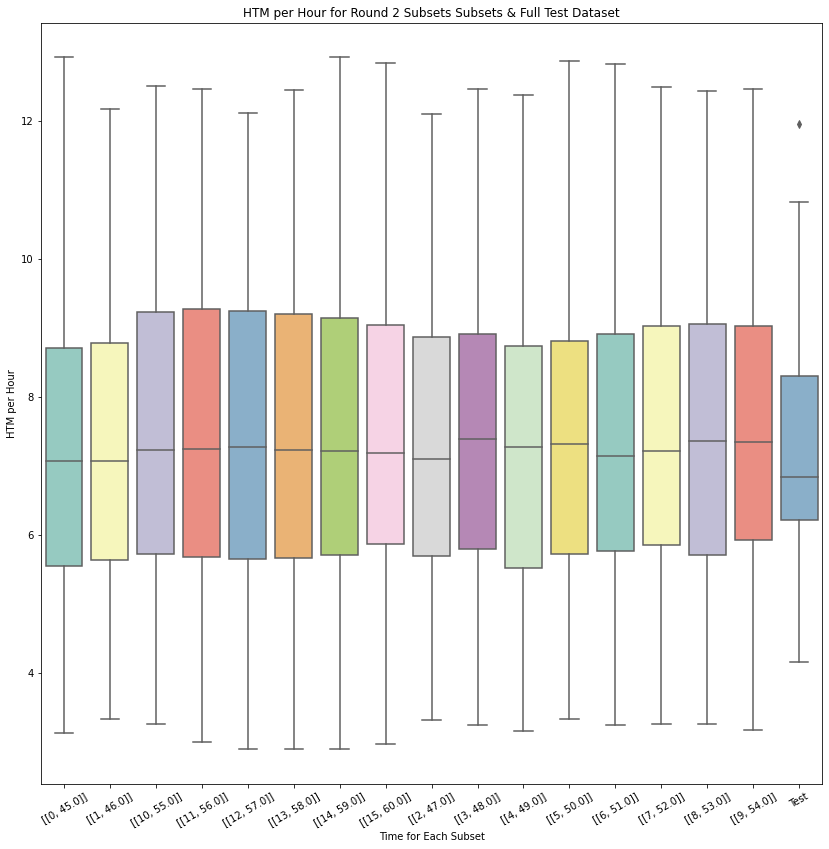

In [32]:
count = 0
for item in conf_dict[2].keys():
  conf_dict[2][str(item)] = conf_dict[2][str(item)].groupby(["hh", "vo.num","htm/hr", "times"])[["recorded_time"]].max().reset_index()
  conf_dict[2][str(item)]["label"] = str(item)

subsets = pd.concat(conf_dict[2].values(), ignore_index=True)

df_full = df_full_test.groupby(["hh", "vo.num","htm/hr"])[["recorded_time"]].max().reset_index()
df_full["label"] = "Test"


full_plotting = pd.concat([subsets, df_full[df_full["vo.num"]=="vo2"]], ignore_index=True)
full_plotting["times"].fillna("Test", inplace=True) 

#concatenate them all together (with the full dataset)

plt.figure(figsize=(14, 14))
ax = sns.boxplot(x="times", y = "htm/hr",
                 data=full_plotting, palette="Set3", orient = "vertical")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

plt.title('HTM per Hour for Round 2 Subsets Subsets & Full Test Dataset')
plt.xlabel('Time for Each Subset')
plt.ylabel('HTM per Hour');



Pt 3: The Best & Worse Subset

In [48]:
#these are the times available that you can select
metric_options = ["mean", "median", "95%"]

def best_subset(priority_metric, percent_choice, all_subsets):
  ##gold standard standard deviation, variance, mean and median

  gold_sd = np.std(df_full_test.groupby(["hh", "vo.num"])[[ "htm/hr"]].max()["htm/hr"])
  gold_var = np.var(df_full_test.groupby(["hh", "vo.num"])[[ "htm/hr"]].max().reset_index()["htm/hr"])

  gold_mean = np.mean(df_full_test.groupby(["hh", "vo.num"])[[ "htm/hr"]].max()["htm/hr"]) + gold_sd
  gold_median = np.median(df_full_test.groupby(["hh", "vo.num"])[[ "htm/hr"]].max()["htm/hr"]) + gold_sd 

  if priority_metric == "mean":

    #starting place to define our best subset
    best_sub = 0

    #storage for averages and the subsets
    avg_dict = {}

    #go through all of our possible subsets from previous function and take the avg of freq column
    for item in all_subsets.values():
      ave = np.mean(item.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"]) + np.std(item.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique())

      #ignore the nan dataframes
      if math.isnan(ave) == True:
        continue

      #store the dataframe as item, the average is the key in the avg_dict dictionary  
      avg_dict[ave] = item
      
    
    #take the difference between the actual average of the training set and each individual subset average
    #whichever has the min absolute value difference is the one we want
    best_avg, best_subset_mean = min(avg_dict.items(), key=lambda x: abs(gold_mean - x[0]))
    
    new_mean = (best_subset_mean.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique())

    print("If you choose to code", percent_choice, "% of each hour of data and prioritize mean of exposure frequency", best_subset_mean["times"].unique(), "\n", "will provide the mean most similar to the full dataset",
          "\n", "it will capture", (np.var(new_mean)/gold_var)*100, "% of the full dataset variance")
    return best_subset_mean


  elif priority_metric == "median": 
     #overall median we want to be closest to

    #starting place to define our best subset
    best_sub = 0

    #storage for medians and the subsets
    median_dict = {}

    #go through all of our possible subsets from previous function and take the avg of freq column
    for item in all_subsets.values():
      med = np.median(item.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique()) + np.std(item.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique())

      #ignore nan dataframes
      if math.isnan(med) == True:
        continue
      

      #store the dataframe as item, the median is the key in the med_dict dictionary 
      median_dict[med] = item
    
    #take the difference between the actual median of the training set and each individual subset median
    #whichever has the min absolute value difference is the one we want
    best_med, best_subset_med = min(median_dict.items(), key=lambda x: abs(gold_median - x[0]))
    
    new_med = np.median(best_subset_med.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique())
    print("If you choose to code", percent_choice, "% of each hour of data and prioritize the median of exposure frequency", best_subset_med["times"].unique(), "\n", "will provide the median most similar to the full dataset",
          "\n", "it will capture", (np.var(best_subset_med.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique())/gold_var)*100, "% of the full dataset variance")
    return best_subset_med

  elif priority_metric == "95%": 
     #overall median we want to be closest to

    #starting place to define our best subset
    best_sub = 0

    #storage for medians and the subsets
    perc_dict = {}

    #go through all of our possible subsets from previous function and take the avg of freq column
    for item in all_subsets.values():
      perc_95 = np.quantile(item.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique(), .95)

      #ignore nan dataframes
      if math.isnan(perc_95) == True:
        continue


      #store the dataframe as item, the median is the key in the med_dict dictionary  
      # item["quality"] = "worst"
      perc_dict[perc_95] = item
    
    #take the difference between the actual median of the training set and each individual subset median
    #whichever has the min absolute value difference is the one we want
    best_perc, best_subset_perc = min(perc_dict.items(), key=lambda x: abs(np.quantile(df_full_test.groupby(["hh", "vo.num","htm/hr"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique(), .95) - x[0]))
    new_med = np.quantile(best_subset_perc.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique(), .95)
    print("If you choose to code", percent_choice, "% of each hour of data and prioritize mean of exposure frequency", best_subset_perc["times"].unique(), "\n", "will provide the mean most similar to the full dataset",
          "\n", "it will capture", (np.var(best_subset_perc.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique())/gold_var)*100, "% of the full dataset variance")
    return best_subset_perc



In [74]:
#these are the times available that you can select
metric_options = ["mean", "median", "95%"]

def worst_subset(priority_metric, percent_choice, all_subsets):
  gold_sd = np.std(df_full_test.groupby(["hh", "vo.num"])[[ "htm/hr"]].max()["htm/hr"])
  gold_var = np.var(df_full_test.groupby(["hh", "vo.num"])[[ "htm/hr"]].max().reset_index()["htm/hr"])

  gold_mean = np.mean(df_full_test.groupby(["hh", "vo.num"])[[ "htm/hr"]].max()["htm/hr"]) + gold_sd
  gold_median = np.median(df_full_test.groupby(["hh", "vo.num"])[[ "htm/hr"]].max()["htm/hr"]) + gold_sd 

  if priority_metric == "mean":

    #starting place to define our best subset
    best_sub = 0

    #storage for averages and the subsets
    avg_dict = {}

    #go through all of our possible subsets from previous function and take the avg of freq column
    for item in all_subsets.values():
      ave = np.mean(item.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"]) + np.std(item.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique())

      #ignore the nan dataframes
      if math.isnan(ave) == True:
        continue

      #store the dataframe as item, the average is the key in the avg_dict dictionary  
      # item["quality"] = "worst"
      avg_dict[ave] = item
    
    #take the difference between the actual average of the training set and each individual subset average
    #whichever has the min absolute value difference is the one we want
    worst_mean, worst_subset_mean = max(avg_dict.items(), key=lambda x: abs(gold_mean - x[0]))
    print("If you choose to code", percent_choice, "% of each hour of data and prioritize mean of exposure frequency", worst_subset_mean["times"].unique(), "\n", "will provide the mean most similar to the full dataset",
          "\n", "it will capture", (np.var((worst_subset_mean.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique()))/gold_var)*100, "% of the full dataset variance")
    return worst_subset_mean


  elif priority_metric == "median": 
     #overall median we want to be closest to

    #starting place to define our best subset
    best_sub = 0

    #storage for medians and the subsets
    median_dict = {}

    #go through all of our possible subsets from previous function and take the avg of freq column
    for item in all_subsets.values():
      med = np.median(item.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique()) + np.std(item.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique())

      #ignore nan dataframes
      if math.isnan(med) == True:
        continue

      #store the dataframe as item, the median is the key in the med_dict dictionary  
      # item["quality"] = "worst"
      median_dict[med] = item
    
    #take the difference between the actual median of the training set and each individual subset median
    #whichever has the min absolute value difference is the one we want
    worst_mean, worst_subset_med = max(median_dict.items(), key=lambda x: abs(gold_median - x[0]))
    print("If you choose to code", percent_choice, "% of each hour of data and prioritize the median of exposure frequency", worst_subset_med["times"].unique(), "\n", "will provide the median most similar to the full dataset",
          "\n", "it will capture", (np.var(worst_subset_med.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique())/gold_var)*100, "% of the full dataset variance")
    return worst_subset_med

  elif priority_metric == "95%": 
     #overall median we want to be closest to

    #starting place to define our best subset
    best_sub = 0

    #storage for medians and the subsets
    perc_dict = {}

    #go through all of our possible subsets from previous function and take the avg of freq column
    for item in all_subsets.values():
      perc_95 = np.quantile(item.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique(), .95)

      #ignore nan dataframes
      if math.isnan(perc_95) == True:
        continue

      #store the dataframe as item, the median is the key in the med_dict dictionary  
      # item["quality"] = "worst"
      perc_dict[perc_95] = item
    
    #take the difference between the actual median of the training set and each individual subset median
    #whichever has the min absolute value difference is the one we want
    worst_perc, worst_subset_perc = max(perc_dict.items(), key=lambda x: abs(np.quantile(df_full_test.groupby(["hh", "vo.num","htm/hr"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique(), .95) - x[0]))
    new_perc = np.quantile(worst_subset_perc["htm/hr"].unique(),.95 )
    print("If you choose to code", percent_choice, "% of each hour of data and prioritize mean of exposure frequency", worst_subset_perc["times"].unique(), "\n", "will provide the mean most similar to the full dataset",
          "\n", "it will capture", (np.var(worst_subset_perc.groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"].unique())/gold_var)*100, "% of the full dataset variance")
    return worst_subset_perc



In [16]:
best_dict = {}

In [ ]:
best_dict = {}
best_dict["best_median_2"] = best_subset("median", 50, conf_dict[1])

In [136]:
worst_dict = {}
worst_dict["worst_median_2"] = worst_subset("median", 50, conf_dict[1])

1
If you choose to code 50 % of each hour of data and prioritize mean of exposure frequency ['[[12, 57.0]]'] 
 will provide the mean most similar to the full dataset 
 it will capture 107.55632498801289 % of the full dataset variance
2
If you choose to code 50 % of each hour of data and prioritize mean of exposure frequency ['[[0, 45.0]]'] 
 will provide the mean most similar to the full dataset 
 it will capture 37.33969346794309 % of the full dataset variance
3
If you choose to code 50 % of each hour of data and prioritize mean of exposure frequency ['[[11, 56.0]]'] 
 will provide the mean most similar to the full dataset 
 it will capture 125.76771245795113 % of the full dataset variance


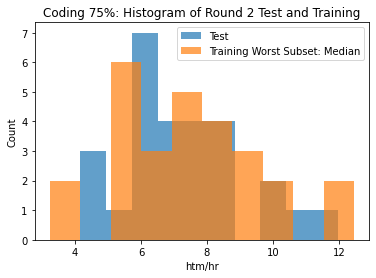

In [82]:


w_m = worst_dict["worst_median_2"].groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"]
true = df_full[df_full["vo.num"]=="vo2"].groupby(["hh", "vo.num","htm/hr"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"]

pyplot.hist(true,alpha = .7, label='Test')
pyplot.hist(w_m, alpha = .7, label='Training Worst Subset: Mean')


pyplot.legend(loc='upper right')
pyplot.xlabel("htm/hr")
pyplot.ylabel("Count")
pyplot.title("Coding 75%: Histogram of Round 2 Test and Training")
pyplot.show()


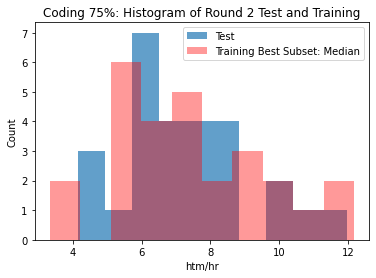

In [83]:
b_m = best_dict["best_median_2"].groupby(["hh", "vo.num","htm/hr", "times"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"]
true = df_full[df_full["vo.num"]=="vo2"].groupby(["hh", "vo.num","htm/hr"])[["htm_cumul", "recorded_time"]].max().reset_index()["htm/hr"]


pyplot.hist(true,alpha = .7, label='Test')
pyplot.hist(b_m, alpha = .4, label='Training Best Subset: Median', color = 'Red')

pyplot.legend(loc='upper right')
pyplot.xlabel("htm/hr")
pyplot.ylabel("Count")
pyplot.title("Coding 75%: Histogram of Round 2 Test and Training")
pyplot.show()

In [ ]:
# Cosine Similarity


# def cosine():
#   a = np.array(df_full.groupby(["hh", "vo.num"])["exp/hr"].max().reset_index()["exp/hr"])
#   a = [a]
#   cos_dict = {}
#   count = 0
#   for item in all_subsets.values():
#     max_cos = 0
#     best_sub = 0
#     b = np.array(item.groupby(["hh", "vo.num"])["exp/hr"].max().reset_index()["exp/hr"])
#     b = [b]
#     cos = cosine_similarity(a, b)
#     cos_dict[cos[0][0]] = item
#     count+=1
#     if cos > max_cos:
#       max_cos = cos
#       best_sub = item.groupby(["hh", "vo.num"])["exp/hr"].max().reset_index()["exp/hr"]
#   print(max_cos, best_sub)
#   return cos_dict


# cos_dict = cosine()

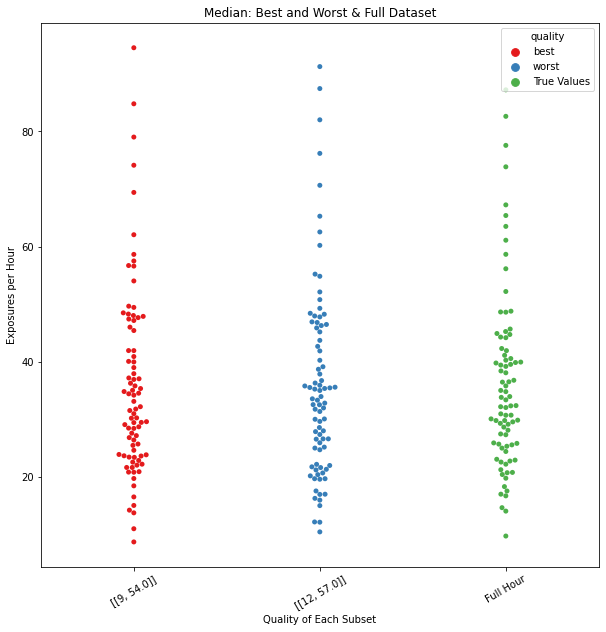

In [ ]:
subset_dict["best_median"]["quality"] = "best"
subset_dict["best_median"]["metric"] = "median"

subset_dict["worst_median"]["quality"] = "worst"
subset_dict["worst_median"]["metric"] = "median"



df_full["quality"] = "True Values"
df_full["metric"] = "NA"


subset_dict["worst_median"] = subset_dict["worst_median"].groupby(["hh", "vo.num","exp/hr", "times", "quality"])[["recorded_time"]].max().reset_index()
subset_dict["best_median"] = subset_dict["best_median"].groupby(["hh", "vo.num","exp/hr", "times", "quality"])[["recorded_time"]].max().reset_index()

subsets = pd.concat(subset_dict.values(), ignore_index=True)

df_full = df_full.groupby(["hh", "vo.num","exp/hr", "quality"])[["recorded_time"]].max().reset_index()

full_plotting = pd.concat([subsets, df_full], ignore_index=True)
full_plotting["times"].fillna("Full Hour", inplace=True) 

#concatenate them all together (with the full dataset)

plt.figure(figsize=(10, 10))
ax = sns.swarmplot(x="times", y = "exp/hr", hue = "quality",
                 data=full_plotting, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

plt.title('Median: Best and Worst & Full Dataset')
plt.xlabel('Quality of Each Subset')
plt.ylabel('Exposures per Hour');

In [4]:
# #Each df is build from separating by vo num and timestamp, and then concatenated together

# def dict_subset_builder(percent_choice, df):
#   per_child = {}

#   hh_list = df["hh"].unique()
#   rounds = df["vo.num"].unique()

#   count = 0

#   df["htm_cumul"] = 0
#   df["htm/hr"] = 0

#   #go through all the children in hh_list
#   for child in hh_list:


#     #create sub dictionary
#     vo_dict = {}


#     count2 = 0

#     for round in rounds:

#       #specify the vo round and child
#       df_vo = df[(df["vo.num"]== str(round)) & (df["hh"]== child)]

#       #get the cumulative sum of recorded time
#       df_vo["record.cumulative"] = df_vo["dur"].shift(1).cumsum().fillna(0)


#       #creating hour running time variable
#       df_vo["recorded_time"] = (pd.to_datetime(df_vo["record.cumulative"], unit="s"))

#       # extracting seconds from time stamp
#       df_vo['recorded_seconds'] = df_vo['recorded_time'].dt.second
#       df_vo['recorded_minutes'] =df_vo['recorded_time'].dt.minute
#       df_vo['recorded_hours'] = df_vo['recorded_time'].dt.hour
#       df_vo["recorded_time"] = df_vo['recorded_time'].dt.time
#       # hour_dict = {}
#       # for value in df_vo["recorded_hours"].unique():  & (df_vo["recorded_hours"] == value)
#       frac = 60*(percent_choice/100)
#       tuple_list = []

#       for i in range(0, 60-int(frac)+1):
#         time_pairs = (i,i + frac)
#         tuple_list.append(time_pairs)

#       #store all possible subsets in a single dictionary
#       time_diction = {}    
#       for i in range(0, len(tuple_list)):
#         time_list = []
#         new_subset = df_vo[(df_vo["recorded_minutes"] >= tuple_list[i][0]) & (df_vo["recorded_minutes"] <= tuple_list[i][1])]

#         #add column for time
#         time_list.append([tuple_list[i][0], tuple_list[i][1]])
#         new_subset["times"] = str(time_list)
        

#         #get cumulative sum of exposures
#         new_subset["htm_cumul"] = new_subset["htm"].cumsum()

#         #Frequency per hour = cumulative number of exposures/total amount of seconds -> converted to hours
#         # new_subset["exp/hr"] = (new_subset["exp_cumul"].max()/(new_subset.tail(1)["recorded_hours"] + new_subset.tail(1)["recorded_minutes"]/60 + new_subset.tail(1)["recorded_seconds"]/(60*60)))
#         new_subset["htm/hr"] = (new_subset["htm_cumul"].max()/new_subset["record.cumulative"].max())*60*60
#         time_diction[i] = new_subset
        
        
      
#       full_time = pd.concat(time_diction.values(), ignore_index=True)

      

#       #add each of our vo dataframes for each child to this sub dictionary
#       vo_dict[count2] = full_time
#       count2 += 1

#     #concatenate the dictionary we just created  
#     vo_full = pd.concat(vo_dict.values(), ignore_index=True)

#     #add it to the larger dictionary
#     per_child[count] = vo_full
#     count += 1


#   #Group dictionary by time rather than child
#   overall = {f'{i}': df for i, (_, df) in 
#        enumerate((pd.concat(per_child.values())).groupby('times'), 1)}


  
#   return overall



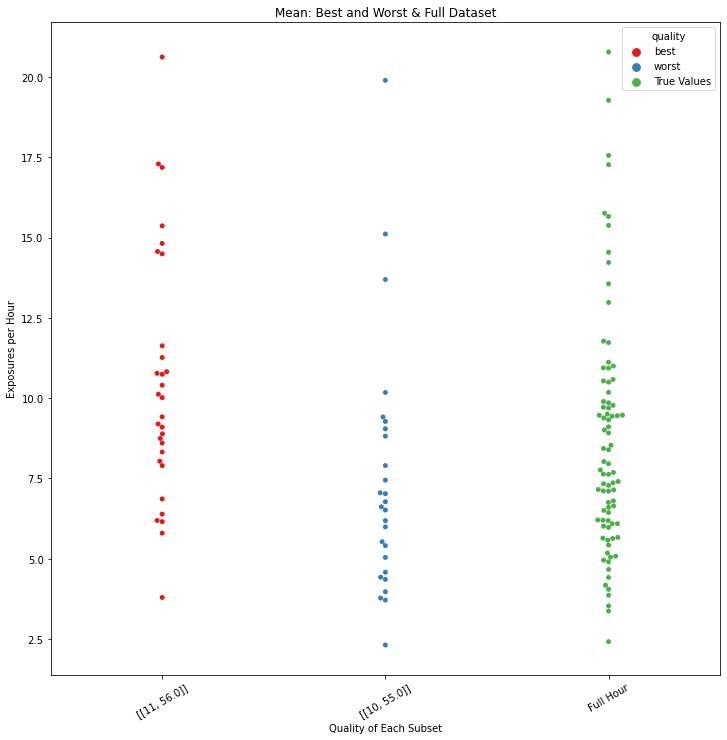

In [ ]:

subset_dict["best_mean"]["quality"] = "best"
subset_dict["best_mean"]["metric"] = "mean"

subset_dict["worst_mean"]["quality"] = "worst"
subset_dict["worst_mean"]["metric"] = "mean"




df_full["quality"] = "True Values"
df_full["metric"] = "NA"

subset_dict["worst_mean"] = subset_dict["worst_mean"].groupby(["hh", "vo.num","htm/hr", "times", "quality"])[["recorded_time"]].max().reset_index()
subset_dict["best_mean"] = subset_dict["best_mean"].groupby(["hh", "vo.num","htm/hr", "times", "quality"])[["recorded_time"]].max().reset_index()


subsets = pd.concat(subset_dict.values(), ignore_index=True)

df_full = df_full.groupby(["hh", "vo.num","htm/hr", "quality"])[["recorded_time"]].max().reset_index()

full_plotting = pd.concat([subsets, df_full], ignore_index=True)
full_plotting["times"].fillna("Full Hour", inplace=True) 

#concatenate them all together (with the full dataset)

plt.figure(figsize=(12, 12))
ax = sns.swarmplot(x="times", y = "htm/hr", hue = "quality",
                 data=full_plotting, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

plt.title('Mean: Best and Worst & Full Dataset')
plt.xlabel('Quality of Each Subset')
plt.ylabel('Exposures per Hour');
